In [81]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from astropy.table import Table
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.umath import * 
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
from astropy.utils.console import ProgressBar

In [2]:
#reading in intial data
hflat=glob('/media/daniel/disk/project_3_Data/calibs/EarlyApril/20200404/h_flats/*.fits')
rflat=glob('/media/daniel/disk/project_3_Data/calibs/EarlyApril/20200404/r_flats/*.fits')
gflat=glob('/media/daniel/disk/project_3_Data/calibs/EarlyApril/20200404/g_flats/*.fits')
bias=glob('/media/daniel/disk/project_3_Data/calibs/EarlyApril/20200404/zeros/*.fits')
m101=glob('/media/daniel/disk/project_3_Data/data/Project_3/Dank_Energy/M101/*.fits')
ngc2903=glob('/media/daniel/disk/project_3_Data/data/Project_3/Dank_Energy/NGC2903/*.fits')
ngc6946=glob('/media/daniel/disk/project_3_Data/data/Project_3/2018_NGC6946/*.fits')
m51=glob('/media/daniel/disk/project_3_Data/data/Project_3/Star_Squad/M51/*.fits')
m82=glob('/media/daniel/disk/project_3_Data/data/Project_3/Wrinkly_Flats/M82/*.fits')
shot_names=m101+ngc2903+ngc6946+m51+m82

In [3]:
#2018 calibrations
calibrations=glob('/media/daniel/disk/project_3_Data/data/Project_3/2018_NGC6946/2018_calibs/*')
y=0
rflat2018=[]
hflat2018=[]
bias2018=[]
while y<len(calibrations):
    cals=fits.open(calibrations[y])
    calshead=cals[0].header
    if calshead['OBJECT']=='Ha_flat':
        hflat2018.append(calibrations[y])
    if calshead['OBJECT']=='r_flat':
        rflat2018.append(calibrations[y])
    if calshead['OBJECT']=='ICEX_zero':
        bias2018.append(calibrations[y])
    y+=1
    

In [4]:
def combinerbias(flat):#pulls a bias, converts to an array, then adds it to the array of arrays
    x=[]
    for y in flat:
        x.append(fits.getdata(y))
    return x

In [439]:
#creating master bias
master_bias=np.median(combinerbias(bias),axis=0)
master_bias2018=np.median(combinerbias(bias2018),axis=0)


In [6]:
def combiner(flat):#pulls a flat, converts to an array, subtracts the master bias, then adds it to the array of arrays
    x=[]
    for y in flat:
        x.append(((fits.getdata(y)-master_bias)))
        
    return x

In [7]:
def make_master_flat(flats):
    master_flat=np.median(combiner(flats),axis=0)
    master_flat=master_flat/np.median(master_flat)
    return master_flat

In [8]:
#creating master flats for both 2020 and 2018
master_hflat=make_master_flat(hflat)
master_rflat=make_master_flat(rflat)
master_gflat=make_master_flat(gflat)

master_hflat2018=make_master_flat(hflat2018)
master_rflat2018=make_master_flat(rflat2018)


In [9]:
#making sub-bias and sub-flats for use with ngc6946
master_bias2018sub=np.zeros((1024,1024))
master_hflat2018sub=np.zeros((1024,1024))
master_rflat2018sub=np.zeros((1024,1024))
for x in range(511,1535):
    for y in range(511,1535):
        master_bias2018sub[y-511][x-511]=master_bias2018[y][x]
        master_rflat2018sub[y-511][x-511]=master_rflat2018[y][x]
        master_hflat2018sub[y-511][x-511]=master_hflat2018[y][x]

In [10]:
# for shot in shots:
#     print(fits.open(shot)[0].header['NAXIS1'],fits.open(shot)[0].header['NAXIS2'], shot)

In [11]:
def imsorter(images): #returns array of arrays, index 0-4 goes u,g,r,i,Ha filter.
    x=0
    returnarray=[]
    g=[]
    u=[]
    i=[]
    r=[]
    h=[]
    while x<len(images):
        hdul = fits.open(images[x])  # open a FITS file
        hdr = hdul[0].header
        if hdr['INSFILTE']=='g':
            g.append(images[x])
        if hdr['INSFILTE']=='u':
            u.append(images[x])
        if hdr['INSFILTE']=='i':
            i.append(images[x])
        if hdr['INSFILTE']=='r':
            r.append(images[x])
        if hdr['INSFILTE']=='Ha' or hdr['INSFILTE']=='H':
            h.append(images[x])
        x+=1
    returnarray.append(u)
    returnarray.append(g)
    returnarray.append(r)
    returnarray.append(i)
    returnarray.append(h)
    
    return returnarray

In [12]:
#sorting images for m101, ngc2903, ngc6946 m51, m82
m101_sorted=imsorter(m101)
ngc2903_sorted=imsorter(ngc2903)
ngc6946_sorted=imsorter(ngc6946)
m51_sorted=imsorter(m51)
m82_sorted=imsorter(m82)
#adding in more m51 stuff manually because header is wrong
m51_sorted[1].append('/media/daniel/disk/project_3_Data/data/Project_3/Flux_Capacitators/M51/M51_xterm_r_suspect_g_WCS.fits')
m51_sorted[2].append('/media/daniel/disk/project_3_Data/data/Project_3/Flux_Capacitators/M51/M51_xterm_i_suspect_r_WCS.fits.fits')
m51_sorted[4].append('/media/daniel/disk/project_3_Data/data/Project_3/Flux_Capacitators/M51/M51_xterm_u_suspect_Ha_WCS.fits.fits')

In [440]:
# allshots=m101_sorted+ngc2903_sorted+ngc6946_sorted+m51_sorted+m82_sorted
# for item in allshots:
#     for arry in item:
#         print(arry)
#         print(fits.open(arry)[0].header['EXPTIME'],fits.open(arry)[0].header['INSFILTE'] )
#         print()

In [14]:
#reading in data to arrays
m101_r=fits.getdata(m101_sorted[2][0]),fits.getdata(m101_sorted[2][1])
m101_ha=[]
for name in m101_sorted[4]:
    m101_ha.append(fits.getdata(name))

ngc2903_g=fits.getdata(ngc2903_sorted[1][0]),fits.getdata(ngc2903_sorted[1][1])
ngc2903_r=fits.getdata(ngc2903_sorted[2][0]),fits.getdata(ngc2903_sorted[2][1])
ngc2903_ha=[]
for name in ngc2903_sorted[4]:
    ngc2903_ha.append(fits.getdata(name))

m51_g=fits.getdata(m51_sorted[1][0]),fits.getdata(m51_sorted[1][1])
m51_r=fits.getdata(m51_sorted[2][0]),fits.getdata(m51_sorted[2][1])
m51_ha=fits.getdata(m51_sorted[4][0]),fits.getdata(m51_sorted[4][1])

m82_g=fits.getdata(m82_sorted[1][0])
m82_r=fits.getdata(m82_sorted[2][0])
m82_ha=fits.getdata(m82_sorted[4][0])

ngc6946_r=fits.getdata(ngc6946_sorted[2][0]),fits.getdata(ngc6946_sorted[2][1])
ngc6946_ha=fits.getdata(ngc6946_sorted[4][0]),fits.getdata(ngc6946_sorted[4][1]),fits.getdata(ngc6946_sorted[4][2])

In [15]:
#applying calibrations. I divide by exposure time to prepare the images for stacking later.
    
m101_r_processed=(m101_r-master_bias)/master_rflat/fits.open(m101_sorted[2][0])[0].header['EXPTIME']
m101_ha_processed=(m101_ha-master_bias)/master_hflat/fits.open(m101_sorted[4][0])[0].header['EXPTIME']

ngc2903_g_processed=(ngc2903_g-master_bias)/master_gflat/fits.open(ngc2903_sorted[1][0])[0].header['EXPTIME']
ngc2903_r_processed=(ngc2903_r-master_bias)/master_rflat/fits.open(ngc2903_sorted[2][0])[0].header['EXPTIME']
ngc2903_ha_processed=(ngc2903_ha-master_bias)/master_hflat/fits.open(ngc2903_sorted[4][0])[0].header['EXPTIME']

m51_g_processed=[]
x=0
while x<len(m51_g):
    m51_g_processed.append(((m51_g[x]-master_bias)/master_gflat)/fits.open(m51_sorted[1][x])[0].header['EXPTIME'])
    x+=1
    
m51_r_processed=[]
x=0
while x<len(m51_r):
    m51_r_processed.append(((m51_r[x]-master_bias)/master_rflat)/fits.open(m51_sorted[2][x])[0].header['EXPTIME'])
    x+=1

m51_ha_processed=[]
x=0
while x<len(m51_ha):
    m51_ha_processed.append(((m51_ha[x]-master_bias)/master_hflat)/fits.open(m51_sorted[4][x])[0].header['EXPTIME'])
    x+=1

m82_g_processed=(m82_g-master_bias)/master_gflat/fits.open(m82_sorted[1][0])[0].header['EXPTIME']
m82_r_processed=(m82_r-master_bias)/master_rflat/fits.open(m82_sorted[2][0])[0].header['EXPTIME']
m82_ha_processed=(m82_ha-master_bias)/master_hflat/fits.open(m82_sorted[4][0])[0].header['EXPTIME']

ngc6946_r_processed=[]
x=0
while x<len(ngc6946_r):
    ngc6946_r_processed.append(((ngc6946_r[x]-master_bias2018sub)/master_rflat2018sub)/fits.open(m51_sorted[2][x])[0].header['EXPTIME'])
    x+=1

ngc6946_ha_processed=(ngc6946_ha-master_bias2018sub)/master_hflat2018sub/fits.open(ngc6946_sorted[4][0])[0].header['EXPTIME']

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: Run

In [16]:
def write_shot(arry, filepath):#only works for arry of arrys
    i=0
    for shot in arry:
        shot_to_write=fits.PrimaryHDU(shot)
        filename=filepath+str(i)+'.fits'
        shot_to_write.writeto(filename,overwrite=True)
        i+=1

In [17]:
#writing to fits file to upload to astrometry
write_shot(m101_r_processed,'/media/daniel/disk/project_3_Data/processed_shots/r/m101r')
write_shot(m101_ha_processed,'/media/daniel/disk/project_3_Data/processed_shots/ha/m101ha')

write_shot(ngc2903_g_processed,'/media/daniel/disk/project_3_Data/processed_shots/g/ngc2903g')
write_shot(ngc2903_r_processed,'/media/daniel/disk/project_3_Data/processed_shots/r/ngc2903r')
write_shot(ngc2903_ha_processed,'/media/daniel/disk/project_3_Data/processed_shots/ha/ngc2903ha')

write_shot(m51_g_processed,'/media/daniel/disk/project_3_Data/processed_shots/g/m51g')
write_shot(m51_r_processed,'/media/daniel/disk/project_3_Data/processed_shots/r/m51r')
write_shot(m51_ha_processed,'/media/daniel/disk/project_3_Data/processed_shots/ha/m51ha')

write_shot(ngc6946_r_processed,'/media/daniel/disk/project_3_Data/processed_shots/ngc6946/ngc6946r')
write_shot(ngc6946_ha_processed,'/media/daniel/disk/project_3_Data/processed_shots/ngc6946/ngc6946ha')

gshot=fits.PrimaryHDU(m82_g_processed)
gshot.writeto('/media/daniel/disk/project_3_Data/processed_shots/g/m82g',overwrite=True)

rshot=fits.PrimaryHDU(m82_r_processed)
rshot.writeto('/media/daniel/disk/project_3_Data/processed_shots/r/m82r',overwrite=True)

hshot=fits.PrimaryHDU(m82_ha_processed)
hshot.writeto('/media/daniel/disk/project_3_Data/processed_shots/ha/m82ha',overwrite=True)

In [33]:
#First round of reprojections
from astropy.utils.data import get_pkg_data_filename
from reproject import reproject_interp
#m51
m51g=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/m51/g/*.fits'))
m51r=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/m51/r/*.fits'))
m51ha=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/m51/ha/*.fits'))
#m101
m101r=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/m101/r/*.fits'))
m101ha=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/m101/ha/*.fits'))
#ngc2903
ngc2903g=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/ngc2903/g/*.fits'))
ngc2903r=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/ngc2903/r/*.fits'))
ngc2903ha=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/ngc2903/ha/*.fits'))
#ngc6946
ngc6946r=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/ngc6946/r/*.fits'))
ngc6946ha=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/ngc6946/ha/*.fits'))
#dont need to reproject for m82 since it has only one shot in each filter

#REPROJECTING BY FILTER
#m51g
j=0
master = fits.open(get_pkg_data_filename(str(m51g[0])))[0]
while j<len(m51g):
    reprojection = fits.open(get_pkg_data_filename(str(m51g[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/m51g'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1

#m51r
j=0
master = fits.open(get_pkg_data_filename(str(m51r[0])))[0]
while j<len(m51r):
    reprojection = fits.open(get_pkg_data_filename(str(m51r[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/m51r'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1
    
#m51ha
j=0
master = fits.open(get_pkg_data_filename(str(m51ha[0])))[0]
while j<len(m51ha):
    reprojection = fits.open(get_pkg_data_filename(str(m51ha[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/m51ha'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1

#m101r
j=0
master = fits.open(get_pkg_data_filename(str(m101r[0])))[0]
while j<len(m101r):
    reprojection = fits.open(get_pkg_data_filename(str(m101r[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/m101r'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1

#m101ha
j=0
master = fits.open(get_pkg_data_filename(str(m101ha[0])))[0]
while j<len(m101ha):
    reprojection = fits.open(get_pkg_data_filename(str(m101ha[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/m101ha'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1

#ngc2903g
j=0
master = fits.open(get_pkg_data_filename(str(ngc2903g[0])))[0]
while j<len(ngc2903g):
    reprojection = fits.open(get_pkg_data_filename(str(ngc2903g[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/ngc2903g'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1

#ngc2903r
j=0
master = fits.open(get_pkg_data_filename(str(ngc2903r[0])))[0]
while j<len(ngc2903r):
    reprojection = fits.open(get_pkg_data_filename(str(ngc2903r[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/ngc2903r'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1

#ngc2903ha
j=0
master = fits.open(get_pkg_data_filename(str(ngc2903ha[0])))[0]
while j<len(ngc2903ha):
    reprojection = fits.open(get_pkg_data_filename(str(ngc2903ha[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/ngc2903ha'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1
    
#ngc6946r
j=0
master = fits.open(get_pkg_data_filename(str(ngc6946r[0])))[0]
while j<len(ngc6946r):
    reprojection = fits.open(get_pkg_data_filename(str(ngc6946r[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/ngc6946r'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1
    
#ngc6946ha
j=0
master = fits.open(get_pkg_data_filename(str(ngc6946ha[0])))[0]
while j<len(ngc6946ha):
    reprojection = fits.open(get_pkg_data_filename(str(ngc6946ha[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/reprojections/ngc6946ha'+str(j)+'.fits', array, master.header, overwrite=True)
    j+=1 
    


In [54]:
#STACKING

#m51
m51g_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/m51g*.fits')
m51r_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/m51r*.fits')
m51ha_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/m51ha*.fits')
#m101
m101r_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/m101r*.fits')
m101ha_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/m101ha*.fits')
#ngc2903
ngc2903g_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/ngc2903g*.fits')
ngc2903r_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/ngc2903r*.fits')
ngc2903ha_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/ngc2903ha*.fits')
#ngc6946
ngc6946r_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/ngc6946r*.fits')
ngc6946ha_reprojected=glob('/media/daniel/disk/project_3_Data/reprojections/ngc6946ha*.fits')

#reading in arrays
#m51
m51g_reprojected_arry=[]
for name in m51g_reprojected:
    m51g_reprojected_arry.append(fits.getdata(name))
    
m51r_reprojected_arry=[]
for name in m51r_reprojected:
    m51r_reprojected_arry.append(fits.getdata(name))
    
m51ha_reprojected_arry=[]
for name in m51ha_reprojected:
    m51ha_reprojected_arry.append(fits.getdata(name))
#m101
m101r_reprojected_arry=[]
for name in m101r_reprojected:
    m101r_reprojected_arry.append(fits.getdata(name))
    
m101ha_reprojected_arry=[]
for name in m101ha_reprojected:
    m101ha_reprojected_arry.append(fits.getdata(name))
#ngc2903
ngc2903g_reprojected_arry=[]
for name in ngc2903g_reprojected:
    ngc2903g_reprojected_arry.append(fits.getdata(name))
    
ngc2903r_reprojected_arry=[]
for name in ngc2903r_reprojected:
    ngc2903r_reprojected_arry.append(fits.getdata(name))
    
ngc2903ha_reprojected_arry=[]
for name in ngc2903ha_reprojected:
    ngc2903ha_reprojected_arry.append(fits.getdata(name))
#ngc6946
ngc6946r_reprojected_arry=[]
for name in ngc6946r_reprojected:
    ngc6946r_reprojected_arry.append(fits.getdata(name))
    
ngc6946ha_reprojected_arry=[]
for name in ngc6946ha_reprojected:
    ngc6946ha_reprojected_arry.append(fits.getdata(name))
    
#STACKING AND WRITING TO FILE. Stacked by taking the mean of all images in a filter
#m51
m51g_stacked=np.mean(m51g_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/m51g_stacked',m51g_stacked)

m51r_stacked=np.mean(m51r_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/m51r_stacked',m51r_stacked)

m51ha_stacked=np.mean(m51ha_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/m51ha_stacked',m51ha_stacked)

#m101
m101r_stacked=np.mean(m101r_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/m101r_stacked',m101r_stacked)

m101ha_stacked=np.mean(m101ha_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/m101ha_stacked',m101ha_stacked)

#ngc2903
ngc2903g_stacked=np.mean(ngc2903g_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/ngc2903g_stacked',ngc2903g_stacked)

ngc2903r_stacked=np.mean(ngc2903r_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/ngc2903r_stacked',ngc2903r_stacked)

ngc2903ha_stacked=np.mean(ngc2903ha_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/ngc2903ha_stacked',ngc2903ha_stacked)

#ngc6946
ngc6946r_stacked=np.mean(ngc6946r_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/ngc6946r_stacked',ngc6946r_stacked)

ngc6946ha_stacked=np.mean(ngc6946ha_reprojected_arry,axis=0)
fits.writeto('/media/daniel/disk/project_3_Data/stacked/ngc6946ha_stacked',ngc6946ha_stacked)

In [78]:
#Reprojecting different filters together for the master images
m51_stacked=sorted(glob('/media/daniel/disk/project_3_Data/stacked_astrometry/*m51*.fits'))
m101_stacked=sorted(glob('/media/daniel/disk/project_3_Data/stacked_astrometry/*m101*.fits'))
m82_stacked=sorted(glob('/media/daniel/disk/project_3_Data/astrometry/m82/*.fits'))
ngc2903_stacked=sorted(glob('/media/daniel/disk/project_3_Data/stacked_astrometry/*ngc2903*.fits'))
ngc6946_stacked=sorted(glob('/media/daniel/disk/project_3_Data/stacked_astrometry/*ngc6946*.fits'))

names=['g','ha','r']

#m51
j=0
master = fits.open(get_pkg_data_filename(str(m51_stacked[0])))[0]
while j<len(m51_stacked):
    reprojection = fits.open(get_pkg_data_filename(str(m51_stacked[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/master_images/m51'+names[j]+'.fits', array, master.header, overwrite=True)
    j+=1
    
#m101
j=0
master = fits.open(get_pkg_data_filename(str(m101_stacked[0])))[0]
while j<len(m101_stacked):
    reprojection = fits.open(get_pkg_data_filename(str(m101_stacked[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/master_images/m101'+names[j+1]+'.fits', array, master.header, overwrite=True)
    j+=1
    
#m82
j=0
master = fits.open(get_pkg_data_filename(str(m82_stacked[0])))[0]
while j<len(m82_stacked):
    reprojection = fits.open(get_pkg_data_filename(str(m82_stacked[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/master_images/m82'+names[j]+'.fits', array, master.header, overwrite=True)
    j+=1

#ngc2903
j=0
master = fits.open(get_pkg_data_filename(str(ngc2903_stacked[0])))[0]
while j<len(ngc2903_stacked):
    reprojection = fits.open(get_pkg_data_filename(str(ngc2903_stacked[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/master_images/ngc2903'+names[j]+'.fits', array, master.header, overwrite=True)
    j+=1
    
#ngc6946
j=0
master = fits.open(get_pkg_data_filename(str(ngc6946_stacked[0])))[0]
while j<len(ngc6946_stacked):
    reprojection = fits.open(get_pkg_data_filename(str(ngc6946_stacked[j])))[0]
    array, footprint = reproject_interp(reprojection, master.header)
    fits.writeto('/media/daniel/disk/project_3_Data/master_images/ngc6946'+names[j+1]+'.fits', array, master.header, overwrite=True)
    j+=1

2
2


In [80]:
#Reading in each Source Extractor catalog for zeropoint calculations
cat_m51g=ascii.read('/media/daniel/disk/project_3_Data/master_images/m51g.cat')
cat_m51ha=ascii.read('/media/daniel/disk/project_3_Data/master_images/m51ha.cat')
cat_m51r=ascii.read('/media/daniel/disk/project_3_Data/master_images/m51r.cat')
cat_m82g=ascii.read('/media/daniel/disk/project_3_Data/master_images/m82g.cat')
cat_m82ha=ascii.read('/media/daniel/disk/project_3_Data/master_images/m82ha.cat')
cat_m82r=ascii.read('/media/daniel/disk/project_3_Data/master_images/m82r.cat')
cat_m101ha=ascii.read('/media/daniel/disk/project_3_Data/master_images/m101ha.cat')
cat_m101r=ascii.read('/media/daniel/disk/project_3_Data/master_images/m101r.cat')
cat_ngc2903g=ascii.read('/media/daniel/disk/project_3_Data/master_images/ngc2903g.cat')
cat_ngc2903ha=ascii.read('/media/daniel/disk/project_3_Data/master_images/ngc2903ha.cat')
cat_ngc2903r=ascii.read('/media/daniel/disk/project_3_Data/master_images/ngc2903r.cat')
cat_ngc6946ha=ascii.read('/media/daniel/disk/project_3_Data/master_images/ngc6946ha.cat')
cat_ngc6946r=ascii.read('/media/daniel/disk/project_3_Data/master_images/ngc6946r.cat')

In [118]:
#Finds the Panstaars matchs for the given catalog in the given band
def panstaars_cat(cat, band):
    ra=np.array(cat['ALPHA_J2000'])
    dec=np.array(cat['DELTA_J2000'])
    flux=np.array(cat['FLUX_AUTO'])
    g=np.where(flux < 0.0) ; flux[g]=1e-30
    mag=(-2.5)*np.log10(flux)
    v = Vizier(columns=['RAJ2000', 'DEJ2000', 'gmag', 'rmag','zmag'])
    ps_mag=np.zeros(len(ra)) # An empty array to fill with the PS (Pan-STAARS) r-band magnitude for my 200 objects
    nr=len(ra) #or len(ra) for full catalog
    errcount=0
    for i in range(0,nr):
        posr = SkyCoord(ra[i]*u.deg, dec[i]*u.deg, frame='icrs') #Make a SkyCoord object for index i of my list of 200 stars
        #print(posr)
        #Query Vizier for sources within 60 arcsec of this position
        try: 
            resultr=v.query_region(posr,width="60s",catalog='panstarrs')[0] 
        except IndexError:
            errcount+=1 
            continue 

        #if this catalog is empty, need to move on
        if len(np.array(resultr['RAJ2000'])) == 0:
            print("catalog is empty. move on")
            continue

        #At this point, I have a lot of sources, since many will be within 60"
        #I only want the closest one, so I need to measure the angular distance
        distr=np.zeros(len(resultr[band])) #Set up an empty distance array
        trar=np.array(resultr['RAJ2000']) #Make a variable for the PANSTARRS RA array
        tdecr=np.array(resultr['DEJ2000']) #Make a variable for the PANSTARRS Dec array
        for j in range(len(distr)): #Run a loop over the PANSTARRS objects to measure the distance
            tobjr=SkyCoord(trar[j]*u.deg,tdecr[j]*u.deg,frame='icrs')
            distr[j]=tobjr.separation(posr).arcsec    

        #Now I have the measured distances. I want the closest one, but only if its close enough I'm sure its the same object
        #I'll be a little liberal, and assume I've found the closest one if its at < 5"
        r=np.where((distr <= 5.0) & (distr==np.min(distr)))[0]
        #print("r is",r)
        rcat = np.asarray(resultr[band][r])
        if len(rcat) == 0:
    #    if not rcat:  #If there is no match, set the mag to some crazy value nowhere near a real value
            ps_mag[i]=float(-99)
            print("No match for index", i)
        else: #If there is a match within 5", then put the PS r-band magnitude in my array
            #print("Match for index", i)
            ps_mag[i] = float(rcat[0])
    #print(ps_mag[0:i+1])
    print('errcount:',errcount)
    return ps_mag

In [104]:
#getting panstaars mags for all bands and objects
ps_gmag_m51=panstaars_cat(cat_m51g,'gmag')
ps_zmag_m51=panstaars_cat(cat_m51ha,'zmag')
ps_rmag_m51=panstaars_cat(cat_m51r,'rmag')

ps_gmag_m82=panstaars_cat(cat_m82g,'gmag')
ps_zmag_m82=panstaars_cat(cat_m82ha,'zmag')
ps_rmag_m82=panstaars_cat(cat_m82r,'rmag')

ps_zmag_m101=panstaars_cat(cat_m101ha,'zmag')
ps_rmag_m101=panstaars_cat(cat_m101r,'rmag')

ps_gmag_ngc2903=panstaars_cat(cat_ngc2903g,'gmag')
ps_zmag_ngc2903=panstaars_cat(cat_ngc2903ha,'zmag')
ps_rmag_ngc2903=panstaars_cat(cat_ngc2903r,'rmag')


ps_rmag_ngc6946=panstaars_cat(cat_ngc6946r,'rmag')

No match for index 0
No match for index 1
No match for index 2
No match for index 5
No match for index 6
No match for index 7
No match for index 9
No match for index 10
No match for index 12
No match for index 14
No match for index 15
No match for index 17
No match for index 18
No match for index 19
No match for index 20
No match for index 21
No match for index 23
No match for index 24
No match for index 26
No match for index 28
No match for index 35
No match for index 40
No match for index 41
No match for index 42
No match for index 43
No match for index 49
No match for index 60
No match for index 61
No match for index 64
No match for index 72
No match for index 74
No match for index 81
No match for index 86
No match for index 88
No match for index 92
No match for index 93
No match for index 97
No match for index 98
No match for index 103
No match for index 111
No match for index 112
No match for index 115
No match for index 120
No match for index 121
No match for index 124
No match f

No match for index 52
No match for index 53
No match for index 54
No match for index 55
No match for index 56
No match for index 57
No match for index 59
No match for index 62
No match for index 70
No match for index 71
No match for index 72
No match for index 73
No match for index 74
No match for index 77
No match for index 79
No match for index 81
No match for index 83
No match for index 87
No match for index 88
No match for index 89
No match for index 90
No match for index 91
No match for index 94
No match for index 95
No match for index 96
No match for index 98
No match for index 105
No match for index 108
No match for index 109
No match for index 110
No match for index 112
No match for index 114
No match for index 115
No match for index 116
No match for index 117
No match for index 119
No match for index 122
No match for index 125
No match for index 126
No match for index 127
No match for index 128
No match for index 131
No match for index 132
No match for index 133
No match for i

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


No match for index 209
No match for index 211
No match for index 213
No match for index 215
No match for index 216
No match for index 217
No match for index 218
No match for index 219
No match for index 220
No match for index 221
No match for index 223
No match for index 225
No match for index 226
No match for index 229
No match for index 231
No match for index 232
No match for index 234
No match for index 236
No match for index 237
No match for index 240
No match for index 241
No match for index 244
No match for index 245
No match for index 246
No match for index 248
No match for index 253
No match for index 256
No match for index 258
No match for index 259
No match for index 263
No match for index 264
No match for index 265
No match for index 266
No match for index 267
No match for index 268
No match for index 269
No match for index 274
No match for index 277
No match for index 279
No match for index 280
No match for index 281
No match for index 288
No match for index 289
No match fo

No match for index 360
No match for index 363
No match for index 364
No match for index 384
No match for index 385
No match for index 390
No match for index 395
No match for index 397
No match for index 401
No match for index 404
No match for index 405
No match for index 406
No match for index 407
No match for index 413
No match for index 414
No match for index 416
No match for index 418
No match for index 432
No match for index 433
No match for index 437
No match for index 441
No match for index 442
No match for index 445
No match for index 447
No match for index 452
No match for index 453
No match for index 454
No match for index 455
No match for index 458
No match for index 461
No match for index 462
No match for index 468
No match for index 474
No match for index 478
No match for index 479
No match for index 486
No match for index 487
No match for index 507
No match for index 508
No match for index 510
No match for index 515
No match for index 518
No match for index 519
No match fo

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


No match for index 114
No match for index 116
No match for index 120
No match for index 123
No match for index 124
No match for index 125
No match for index 127
No match for index 128
No match for index 129
No match for index 132
No match for index 133
No match for index 134
No match for index 135
No match for index 136
No match for index 137
No match for index 138
No match for index 140
No match for index 141
No match for index 143
No match for index 144
No match for index 148
No match for index 149
No match for index 153
No match for index 155
No match for index 159
No match for index 161
No match for index 162
No match for index 164
No match for index 167
No match for index 168
No match for index 169
No match for index 170
No match for index 171
No match for index 175
No match for index 176
No match for index 177
No match for index 180
No match for index 181
No match for index 183
No match for index 184
No match for index 186
No match for index 187
No match for index 188
No match fo

No match for index 301
No match for index 302
No match for index 303
No match for index 306
No match for index 307
No match for index 308
No match for index 313
No match for index 315
No match for index 317
No match for index 318
No match for index 320
No match for index 321
No match for index 322
No match for index 324
No match for index 326
No match for index 327
No match for index 329
No match for index 331
No match for index 332
No match for index 335
No match for index 336
No match for index 337
No match for index 338
No match for index 339
No match for index 340
No match for index 342
No match for index 343
No match for index 344
No match for index 345
No match for index 346
No match for index 350
No match for index 351
No match for index 354
No match for index 355
No match for index 360
No match for index 361
No match for index 362
errcount: 9
No match for index 0
No match for index 2
No match for index 3
No match for index 5
No match for index 6
No match for index 7
No match fo

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


No match for index 147
No match for index 149
No match for index 150
No match for index 151
No match for index 154
No match for index 155
No match for index 157
No match for index 158
No match for index 160
No match for index 161
No match for index 163
No match for index 164
No match for index 166
No match for index 167
No match for index 168
No match for index 170
No match for index 171
No match for index 175
No match for index 176
No match for index 178
No match for index 179
No match for index 180
No match for index 181
No match for index 183
No match for index 186
No match for index 190
No match for index 191
No match for index 192
No match for index 193
No match for index 195
No match for index 196
No match for index 197
No match for index 200
No match for index 201
No match for index 203
No match for index 206
No match for index 208
No match for index 211
No match for index 212
No match for index 215
No match for index 217
No match for index 218
No match for index 219
No match fo

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


No match for index 260
No match for index 261
No match for index 262
No match for index 266
No match for index 267
No match for index 271
No match for index 272
No match for index 274
No match for index 275
No match for index 276
No match for index 278
No match for index 279
No match for index 281
No match for index 282
No match for index 284
No match for index 285
No match for index 286
No match for index 287
No match for index 292
No match for index 293
No match for index 294
No match for index 295
No match for index 297
No match for index 299
No match for index 300
No match for index 302
No match for index 305
No match for index 306
No match for index 307
No match for index 310
No match for index 311
No match for index 313
No match for index 315
No match for index 316
No match for index 319
No match for index 323
No match for index 327
No match for index 329
No match for index 331
No match for index 334
No match for index 335
No match for index 337
No match for index 338
No match fo

No match for index 1121
No match for index 1129
No match for index 1131
No match for index 1132
No match for index 1141
No match for index 1160
No match for index 1165
No match for index 1177
No match for index 1182
No match for index 1192
No match for index 1211
No match for index 1236
No match for index 1241
No match for index 1248
No match for index 1259
No match for index 1261
No match for index 1271
No match for index 1281
No match for index 1303
No match for index 1322
No match for index 1328
No match for index 1329
No match for index 1345
No match for index 1347
No match for index 1352
No match for index 1377
No match for index 1380
No match for index 1381
No match for index 1382
No match for index 1399
No match for index 1407
No match for index 1408
No match for index 1410
No match for index 1422
No match for index 1423
No match for index 1435
No match for index 1444
No match for index 1447
No match for index 1474
No match for index 1477
No match for index 1483
No match for ind

No match for index 893
No match for index 895
No match for index 898
No match for index 901
No match for index 902
No match for index 903
No match for index 904
No match for index 908
No match for index 911
No match for index 912
No match for index 914
No match for index 916
No match for index 919
No match for index 922
No match for index 925
No match for index 928
No match for index 929
No match for index 931
No match for index 932
No match for index 934
No match for index 937
No match for index 938
No match for index 944
No match for index 948
No match for index 951
No match for index 952
No match for index 955
No match for index 957
No match for index 959
No match for index 960
No match for index 967
No match for index 971
No match for index 977
No match for index 989
No match for index 990
No match for index 995
No match for index 997
No match for index 1003
No match for index 1006
No match for index 1007
No match for index 1024
No match for index 1027
No match for index 1030
No ma

No match for index 516
No match for index 521
No match for index 522
No match for index 542
No match for index 546
No match for index 547
No match for index 555
No match for index 556
No match for index 566
No match for index 567
No match for index 575
No match for index 583
No match for index 588
No match for index 591
No match for index 601
No match for index 605
No match for index 611
No match for index 612
No match for index 616
No match for index 622
No match for index 630
No match for index 632
No match for index 636
No match for index 639
No match for index 642
No match for index 644
No match for index 646
No match for index 647
No match for index 649
No match for index 651
No match for index 674
No match for index 681
No match for index 686
No match for index 691
No match for index 692
No match for index 700
No match for index 707
No match for index 716
No match for index 720
No match for index 722
No match for index 728
No match for index 737
No match for index 740
No match fo

In [119]:
ps_hamag_ngc6946=panstaars_cat(cat_ngc6946ha,'rmag')#can use rmag here since it is an actual Ha shot

No match for index 8


/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


No match for index 16
No match for index 31
No match for index 50
No match for index 54
No match for index 86
No match for index 123
No match for index 172
No match for index 173
No match for index 181
No match for index 183
No match for index 204
No match for index 225
No match for index 254
No match for index 315
No match for index 322
No match for index 357
No match for index 371
No match for index 392
No match for index 445
No match for index 600
No match for index 747
No match for index 818
No match for index 841
No match for index 865
No match for index 877
No match for index 883
No match for index 948
No match for index 953
No match for index 984
No match for index 1024
No match for index 1028
No match for index 1035
No match for index 1055
No match for index 1113
No match for index 1154
No match for index 1155
No match for index 1160
No match for index 1169
No match for index 1184
No match for index 1193
No match for index 1241
No match for index 1251
No match for index 1287
No

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal


No match for index 1378
No match for index 1392
No match for index 1457
No match for index 1486
No match for index 1552
No match for index 1607
errcount: 0


In [121]:
def mag(flux_arry):#just a helpful little method to calculate magnitudes from flux
    return -2.5*np.log10(flux_arry)

In [175]:
def zp_helper(ps, mag, *args):#graphs correlation between Panstaars mags and instrumental mags
    index=np.where(ps>0)
    plt.figure()
    plt.scatter(ps[index],ps[index]-mag[index], s=0.5)
    if len(args)>0:
        plt.xlim(args[0],args[1])
        plt.ylim(args[2],args[3])

In [434]:
def zp_helper_nice(ps, mag, title, band, *args):#graphs correlation between Panstaars mags and instrumental mags with extra options for displaying
    index=np.where(ps>0)
    plt.figure()
    plt.scatter(ps[index],ps[index]-mag[index], s=0.5)
    plt.title(title, fontsize=20)
    plt.xlabel('Panstaars '+band+'mag',fontsize=14)
    plt.ylabel('Panstaars '+band+'mag - Instrumental '+band+'mag',fontsize=14)
    if len(args)>0:
        plt.xlim(args[0],args[1])
        plt.ylim(args[2],args[3])
    plt.savefig(title,bbox_inches='tight', dpi=300)

In [202]:
def zp_calc(ps,mag,xmin,xmax,ymin,ymax):#returns the zeropoint
    index=np.where((ps<xmax)&(ps>xmin)&((ps-mag)<ymax)&((ps-mag)>ymin))
    zp=np.nanmedian(ps[index]-mag[index])
    print('zp:',zp)
    return zp

In [ ]:
#converting from Fluxes to magnitudes
zmag_m51=mag(cat_m51ha['FLUX_AUTO'])
rmag_m51=mag(cat_m51r['FLUX_AUTO'])

zmag_m82=mag(cat_m82ha['FLUX_AUTO'])
rmag_m82=mag(cat_m82r['FLUX_AUTO'])

zmag_m101=mag(cat_m101ha['FLUX_AUTO'])
rmag_m101=mag(cat_m101r['FLUX_AUTO'])

zmag_ngc2903=mag(cat_ngc2903ha['FLUX_AUTO'])
rmag_ngc2903=mag(cat_ngc2903r['FLUX_AUTO'])

hamag_ngc6946=mag(cat_ngc6946ha['FLUX_AUTO'])
rmag_ngc6946=mag(cat_ngc6946r['FLUX_AUTO'])

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/daniel/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/home/daniel/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


zp: 21.36727861465328
zp: 19.44596785869208


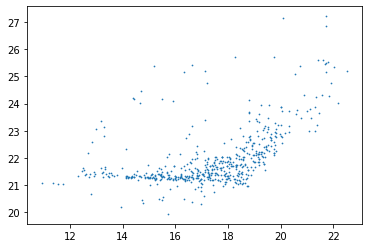

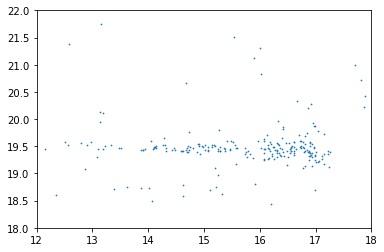

In [431]:
#Beginning of zeropoint calculations
#m51 zeropoint calculation
zp_helper(ps_rmag_m51,rmag_m51)
zp_m51r=zp_calc(ps_rmag_m51,rmag_m51,14,19,21,22)
zp_helper(ps_zmag_m51,zmag_m51,12,18,18,22)
zp_m51z=zp_calc(ps_zmag_m51,zmag_m51, 14,17.5,19,20)

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


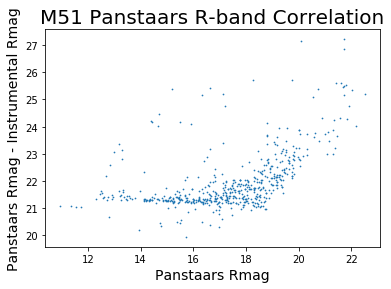

In [435]:
zp_helper_nice(ps_rmag_m51, rmag_m51, 'M51 Panstaars R-band Correlation','R')

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


zp: 15.699490931379872
zp: 16.955675637342964


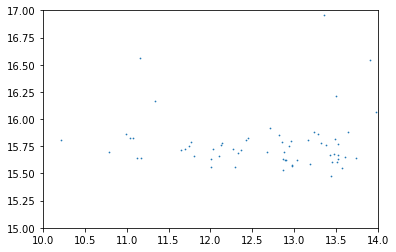

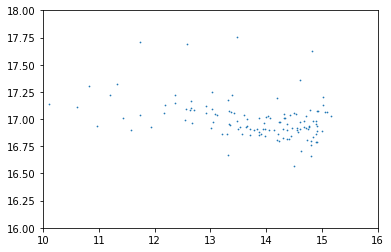

In [209]:
#m82 zeropoint calculation
zp_helper(ps_zmag_m82,zmag_m82,10,14,15,17)
zp_m82z=zp_calc(ps_zmag_m82,zmag_m82,10,14,15.4,16)
zp_helper(ps_rmag_m82,rmag_m82,10,16,16,18)
zp_m82r=zp_calc(ps_rmag_m82,rmag_m82,12,15.5,16.5,17.25)

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


zp: 20.49388543839987
zp: 21.460239168065605


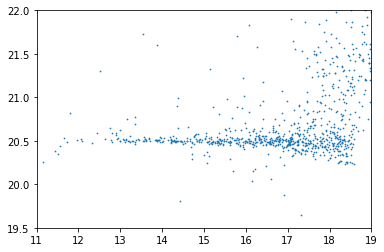

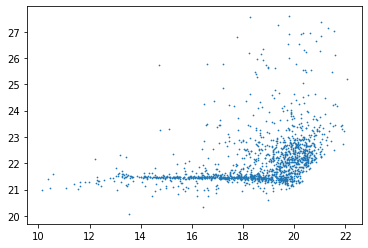

In [205]:
#m101 zeropoint calculation
zp_helper(ps_zmag_m101,zmag_m101,11,19,19.5,22)
zp_m101z=zp_calc(ps_zmag_m101,zmag_m101,13,18.75,20.1,20.65)
zp_helper(ps_rmag_m101,rmag_m101)
zp_m101r=zp_calc(ps_rmag_m101,rmag_m101,13.5,20.5,21,21.75)

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


zp: 20.453027933230217
zp: 21.44717695677954


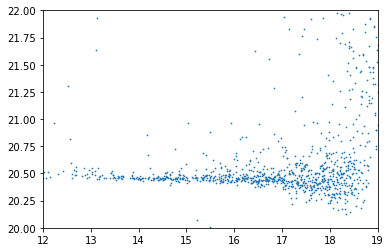

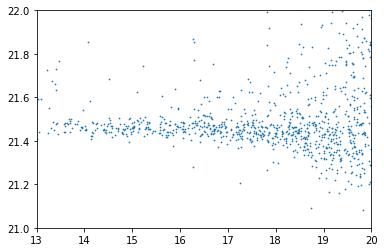

In [212]:
#ngc2903 zeropoint calculation
zp_helper(ps_zmag_ngc2903,zmag_ngc2903,12,19,20,22)
zp_ngc2903z=zp_calc(ps_zmag_ngc2903,zmag_ngc2903,12,19,20,20.6)
zp_helper(ps_rmag_ngc2903,rmag_ngc2903,13,20,21,22)
zp_ngc2903r=zp_calc(ps_rmag_ngc2903,rmag_ngc2903,13,20.25,21.2,21.6)

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


zp: 19.620339063576292
zp: 21.74911168897612


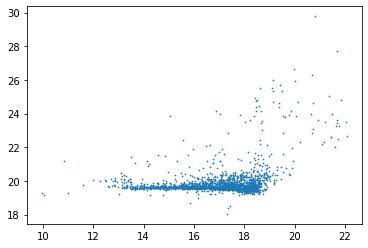

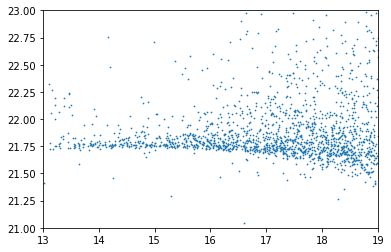

In [218]:
#ngc6946 zeropoint calculation
zp_helper(ps_hamag_ngc6946,hamag_ngc6946)
zp_ngc6946ha=zp_calc(ps_hamag_ngc6946,hamag_ngc6946,13,19,19,20)
zp_helper(ps_rmag_ngc6946,rmag_ngc6946,13,19,21,23)
zp_ngc6946r=zp_calc(ps_rmag_ngc6946,rmag_ngc6946,13,19,21.5,21.85)

In [255]:
#loading in master images for zeropoint correction. g,ha,r
m51_master=sorted(glob('/media/daniel/disk/project_3_Data/master_images/m51*.fits'))
m82_master=sorted(glob('/media/daniel/disk/project_3_Data/master_images/m82*.fits'))
m101_master=sorted(glob('/media/daniel/disk/project_3_Data/master_images/m101*.fits'))
ngc2903_master=sorted(glob('/media/daniel/disk/project_3_Data/master_images/ngc2903*.fits'))
ngc6946_master=sorted(glob('/media/daniel/disk/project_3_Data/master_images/ngc6946*.fits'))

m51_master_arry=[]
for name in m51_master:
    m51_master_arry.append(fits.getdata(name))

m82_master_arry=[]
for name in m82_master:
    m82_master_arry.append(fits.getdata(name))
    
m101_master_arry=[]
for name in m101_master:
    m101_master_arry.append(fits.getdata(name))
    
ngc2903_master_arry=[]
for name in ngc2903_master:
    ngc2903_master_arry.append(fits.getdata(name))
    
ngc6946_master_arry=[]
for name in ngc6946_master:
    ngc6946_master_arry.append(fits.getdata(name))
    
#applying zeropoint to images
m51z_calib=m51_master_arry[1]*10.**(-0.4*48.6-0.4*zp_m51z)*1.0e29
m51r_calib=m51_master_arry[2]*10.**(-0.4*48.6-0.4*zp_m51r)*1.0e29

m82z_calib=m82_master_arry[1]*10.**(-0.4*48.6-0.4*zp_m82z)*1.0e29
m82r_calib=m82_master_arry[2]*10.**(-0.4*48.6-0.4*zp_m82r)*1.0e29

m101z_calib=m101_master_arry[0]*10.**(-0.4*48.6-0.4*zp_m101z)*1.0e29
m101r_calib=m101_master_arry[1]*10.**(-0.4*48.6-0.4*zp_m101r)*1.0e29

ngc2903z_calib=ngc2903_master_arry[1]*10.**(-0.4*48.6-0.4*zp_ngc2903z)*1.0e29
ngc2903r_calib=ngc2903_master_arry[2]*10.**(-0.4*48.6-0.4*zp_ngc2903r)*1.0e29

ngc6946ha_calib=ngc6946_master_arry[0]*10.**(-0.4*48.6-0.4*zp_ngc6946ha)*1.0e29
ngc6946r_calib=ngc6946_master_arry[1]*10.**(-0.4*48.6-0.4*zp_ngc6946r)*1.0e29

In [256]:
#writes given array to give filepath
def writer(arry, filepath):
    shot=fits.PrimaryHDU(arry)
    shot.writeto(filepath,overwrite=True)

In [274]:
#creating subimages to isolate galaxy
#m51 840,1150 to 1220,500
#m82 865,875 to 1140,710
#m101 615,1190 to 1540,180
#ngc2903 850,1235 to 1125,715
#ngc6946 295,525 to 725,140
m51z_sub=np.zeros((650,380))
m51r_sub=np.zeros((650,380))
for x in range(840,1220):
    for y in range(500,1150):
        m51z_sub[y-500][x-840]=m51z_calib[y][x]
        m51r_sub[y-500][x-840]=m51r_calib[y][x]

m82z_sub=np.zeros((165,275))
m82r_sub=np.zeros((165,275))
for x in range(865,1140):
    for y in range(710,875):
        m82z_sub[y-710][x-865]=m82z_calib[y][x]
        m82r_sub[y-710][x-865]=m82r_calib[y][x]
        
m101z_sub=np.zeros((1010,925))
m101r_sub=np.zeros((1010,925))
for x in range(615,1540):
    for y in range(180,1190):
        m101z_sub[y-180][x-615]=m101z_calib[y][x]
        m101r_sub[y-180][x-615]=m101r_calib[y][x]
        
ngc2903z_sub=np.zeros((520,275))
ngc2903r_sub=np.zeros((520,275))
for x in range(850,1125):
    for y in range(715,1235):
        ngc2903z_sub[y-715][x-850]=ngc2903z_calib[y][x]
        ngc2903r_sub[y-715][x-850]=ngc2903r_calib[y][x]
        
ngc6946ha_sub=np.zeros((385,430))
ngc6946r_sub=np.zeros((385,430))
for x in range(295,725):
    for y in range(140,525):
        ngc6946ha_sub[y-140][x-295]=ngc6946ha_calib[y][x]
        ngc6946r_sub[y-140][x-295]=ngc6946r_calib[y][x]

#writing to file
writer(m51z_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/m51z')
writer(m51r_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/m51r')
writer(m82z_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/m82z')
writer(m82r_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/m82r')
writer(m101z_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/m101z')
writer(m101r_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/m101r')
writer(ngc2903z_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/ngc2903z')
writer(ngc2903r_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/ngc2903r')
writer(ngc6946ha_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/ngc6946ha')
writer(ngc6946r_sub,'/media/daniel/disk/project_3_Data/calibrated_subimages/ngc6946r')

In [266]:
#do some convolving to use convolved difference images as the detection images and writing the convolved difference images to file
from astropy.convolution import convolve

g = Gaussian2DKernel(5)
writer(convolve(m51r_sub, g)-convolve(m51z_sub, g),'/media/daniel/disk/project_3_Data/convolved/m51_convl.fits')
writer(convolve(m82r_sub, g)-convolve(m82z_sub, g),'/media/daniel/disk/project_3_Data/convolved/m82_convl.fits')
writer(convolve(m101r_sub, g)-convolve(m101z_sub, g),'/media/daniel/disk/project_3_Data/convolved/m101_convl.fits')
writer(convolve(ngc2903r_sub, g)-convolve(ngc2903z_sub, g),'/media/daniel/disk/project_3_Data/convolved/ngc2903_convl.fits')
writer(convolve(ngc6946ha_sub, g)-convolve(ngc6946r_sub, g),'/media/daniel/disk/project_3_Data/convolved/ngc6946_convl.fits')


In [258]:
# #making difference images
# #ha-r and r-z
# writer(m51r_sub-m51z_sub,'/media/daniel/disk/project_3_Data/difference_images/m51_diff.fits')
# writer(m82r_sub-m82z_sub,'/media/daniel/disk/project_3_Data/difference_images/m82_diff.fits')
# writer(m101r_sub-m101z_sub,'/media/daniel/disk/project_3_Data/difference_images/m101_diff.fits')
# writer(ngc2903r_sub-ngc2903z_sub,'/media/daniel/disk/project_3_Data/difference_images/ngc2903_diff.fits')
# writer(ngc6946ha_sub-ngc6946r_sub,'/media/daniel/disk/project_3_Data/difference_images/ngc6946_diff.fits')

Looks like only NGC6946 and M101 have any meaningful information

In [346]:
def fluxarry(cat, wavelength):#reads out flux and flux err, converts from uJy to ergs and flux in wavelength
    arry=[]
    for row in cat:
        arry.append(ufloat(row['FLUX_AUTO'],row['FLUXERR_AUTO'])*1e-29*3*1e18/(wavelength**2))
    return arry

In [358]:
#reading in fluxes
#using uncertainties package to track changes in error (.nominal_values,.std_devs)
from astropy.io import ascii
ngc6946ha_cat=ascii.read('/media/daniel/disk/project_3_Data/calibrated_subimages/ngc6946ha.cat')
ngc6946r_cat=ascii.read('/media/daniel/disk/project_3_Data/calibrated_subimages/ngc6946r.cat')
m101z_cat=ascii.read('/media/daniel/disk/project_3_Data/calibrated_subimages/m101z.cat')
m101r_cat=ascii.read('/media/daniel/disk/project_3_Data/calibrated_subimages/m101r.cat')
ngc6946ha_flux=fluxarry(ngc6946ha_cat,6563)
ngc6946r_flux=fluxarry(ngc6946r_cat,6170)
m101z_flux=fluxarry(m101z_cat,8780)
m101r_flux=fluxarry(m101r_cat,6170)

In [362]:
#flux Ha for NGC6946
ngc6946_realfluxha=[]
for x in range(0,len(ngc6946ha_flux)):
    ngc6946_realfluxha.append((ngc6946r_flux[x]-ngc6946ha_flux[x])/(1/1125-1/50))
# flux_hist=[]
# for item in ngc6946_realfluxha:
#     flux_hist.append(item.nominal_value)
# plt.hist(flux_hist,30)

#flux r for m101
m101_realfluxr=[]
for x in range(0,len(m101r_flux)):
    m101_realfluxr.append(1125*((m101r_flux[x]-m101z_flux[x])*((6170**0.5)/(8780**0.5))))

In [367]:
#finding luminosities
#distance to ngc6946 = 2.222e25cm
#distance to m101 = 1.851e25cm
lumin_ngc6946=[]
for x in range(0,len(ngc6946_realfluxha)):
    lumin_ngc6946.append((4*np.pi*(2.222e25)**2*ngc6946_realfluxha[x]))
    
lumin_m101=[]
for x in range(0,len(m101_realfluxr)):
    lumin_m101.append((4*np.pi*(1.851e25)**2*m101_realfluxr[x]))

/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/home/daniel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/daniel/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/daniel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


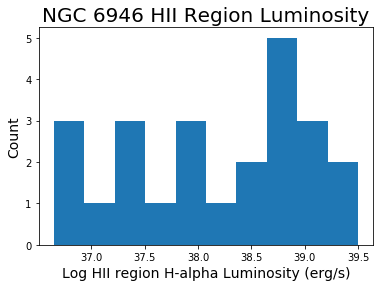

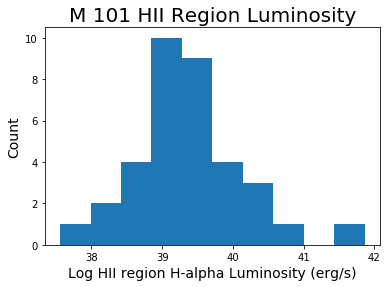

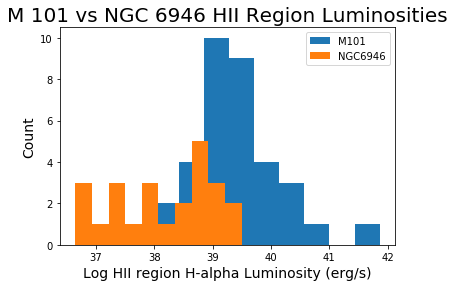

In [437]:
#making graphs #note to self can use unumpy.nominal_values(arr) instead of for loops
lum_ngc6946=[]
for item in lumin_ngc6946:
    lum_ngc6946.append(item.nominal_value)
    
lum_m101=[]
for item in lumin_m101:
    lum_m101.append(item.nominal_value)
    
#log luminosity ergs/sec
plt.figure()
plt.title('NGC 6946 HII Region Luminosity', fontsize=20)
plt.xlabel('Log HII region H-alpha Luminosity (erg/s)',fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.hist(np.log10(lum_ngc6946))
plt.savefig('NGC 6946 HII Region Luminosity', bbox_inches='tight', dpi=300)


plt.figure()
plt.title('M 101 HII Region Luminosity', fontsize=20)
plt.xlabel('Log HII region H-alpha Luminosity (erg/s)',fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.hist(np.log10(lum_m101))
plt.savefig('M 101 HII Region Luminosity', bbox_inches='tight', dpi=300)

plt.figure()
plt.title('M 101 vs NGC 6946 HII Region Luminosities', fontsize=20)
plt.hist(np.log10(lum_m101),label='M101')
plt.hist(np.log10(lum_ngc6946),label='NGC6946')
plt.xlabel('Log HII region H-alpha Luminosity (erg/s)',fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend()
plt.savefig('M 101 vs NGC 6946 HII Region Luminosities', bbox_inches='tight', dpi=300)



M101 Z-Band Err: 28.018936562500002
M101 R-Band Err: 13.286936454545454
NGC6946 Ha-Band Err: 56.58662574074074
NGC6946 R-Band Err: 64.50496485294117


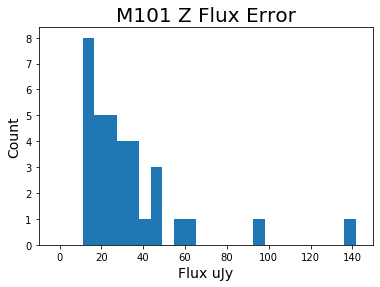

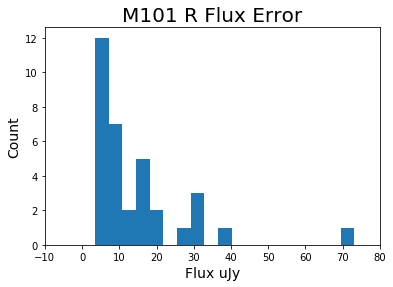

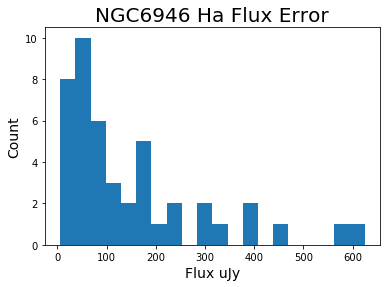

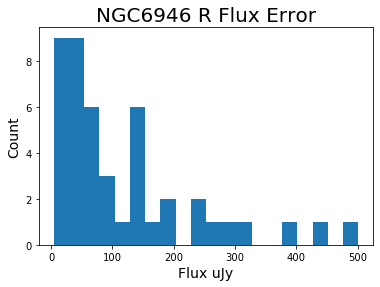

In [436]:

#calculating error in flux measurements by taking the mean of all flux_err that do not appear to be outliers

plt.figure()
plt.title('M101 Z Flux Error', fontsize=20)
plt.hist(m101z_cat['FLUXERR_AUTO'],300)
plt.xlim(-10,150)
plt.xlabel('Flux uJy',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.savefig('M101 Z Flux Error',bbox_inches='tight', dpi=300)
err1=m101z_cat['FLUXERR_AUTO']
i=np.where(err1<80)
print('M101 Z-Band Err:',np.mean(err1[i]))

plt.figure()
plt.title('M101 R Flux Error', fontsize=20)
plt.hist(m101r_cat['FLUXERR_AUTO'],300)
plt.xlim(-10,80)
plt.xlabel('Flux uJy',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.savefig('M101 R Flux Error',bbox_inches='tight', dpi=300)
err2=m101r_cat['FLUXERR_AUTO']
i=np.where(err2<50)
print('M101 R-Band Err:',np.mean(err2[i]))

plt.figure()
plt.title('NGC6946 Ha Flux Error', fontsize=20)
plt.hist(ngc6946ha_cat['FLUXERR_AUTO'],20)
plt.xlabel('Flux uJy',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.savefig('NGC6946 Ha Flux Error',bbox_inches='tight', dpi=300)
err3=ngc6946ha_cat['FLUXERR_AUTO']
i=np.where(err3<150)
print('NGC6946 Ha-Band Err:',np.mean(err3[i]))

plt.figure()
plt.title('NGC6946 R Flux Error', fontsize=20)
plt.hist(ngc6946r_cat['FLUXERR_AUTO'],20)
plt.xlabel('Flux uJy',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.savefig('NGC6946 R Flux Error',bbox_inches='tight', dpi=300)
err4=ngc6946r_cat['FLUXERR_AUTO']
i=np.where(err4<150)
print('NGC6946 R-Band Err:',np.mean(err4[i]))